In [7]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [14]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_erro

ModuleNotFoundError: No module named 'statsmodels'

## 1. Datos: Precipitaciones, Indicadores Económicos Banco Central

In [37]:
precip=pd.read_csv('precipitaciones.csv')
bc=pd.read_csv('banco_central.csv')

## 2. Análisis de datos. Creación de variables


In [24]:
#Revisamos si existen valores nulos
precip.isna().sum()

date                                   0
Coquimbo                               0
Valparaiso                             0
Metropolitana_de_Santiago              0
Libertador_Gral__Bernardo_O_Higgins    0
Maule                                  0
Biobio                                 0
La_Araucania                           0
Los_Rios                               0
dtype: int64

In [25]:
# Existen varios valores nulos en este caso.  
bc.isna().sum()

Periodo                                              0
Imacec_empalmado                                   314
Imacec_produccion_de_bienes                        314
Imacec_minero                                      314
Imacec_industria                                   313
                                                  ... 
Generacion_de_energia_electrica_CDEC_GWh           350
Indice_de_ventas_comercio_real_IVCM                530
Indice_de_ventas_comercio_real_no_durables_IVCM    530
Indice_de_ventas_comercio_real_durables_IVCM       529
Ventas_autos_nuevos                                469
Length: 85, dtype: int64

In [256]:
# Removemos strings que puedan estar en los números erróneamentre y convertimos las variables a enteras para poder utlizarlas como números

string_columns=bc.columns[bc.dtypes=='O'][1:] #No inicluimos la primera columna, correspondiente a la fecha
for column in string_columns:
    bc[column]= bc[column].str.replace('.', "")
    bc[column]= bc[column].str.extract('(\d+)', expand=False)
    bc[column]= pd.to_numeric(bc[column], downcast="integer")
#     bc[column]= bc[column].map(lambda x: x/(10**(len(str(x))-4))) 


/var/folders/sd/z1yyb5217c15w6j93f40c9s40000gn/T/ipykernel_28681/3729627011.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bc[column]= bc[column].str.replace('.', "")


In [28]:
#Eliminamos filas duplicadas.           
precip.drop_duplicates(inplace=True)
bc.drop_duplicates(inplace=True)


,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
0,2013-03-01 00:00:00 UTC,102796218.0,10546824.0,978554365.0,102297537.0,114994919.0,110729395.0,100064328.0,103163651.0,103405852.0,...,865903468.0,102761705.0,98915705.0,NaN,108387837.0,580480672.0,NaN,NaN,NaN,28577.0
1,2013-04-01 00:00:00 UTC,101664842.0,999272757.0,927333293.0,104485589.0,102199311.0,106098291.0,102600107.0,101937319.0,102766884.0,...,867806065.0,968087179.0,914276663.0,NaN,104545429.0,544815032.0,NaN,NaN,NaN,32206.0
2,2013-05-01 00:00:00 UTC,101642954.0,993959922.0,96133164.0,105445361.0,968789055.0,100462117.0,104083216.0,101953299.0,102322796.0,...,878030947.0,978471874.0,966913278.0,NaN,99468801.0,56891916.0,NaN,NaN,NaN,31589.0
3,2013-06-01 00:00:00 UTC,998310201.0,968367884.0,102400933.0,999212106.0,89190493.0,939504414.0,103857161.0,100222381.0,995139235.0,...,913180348.0,966647135.0,981820974.0,NaN,94969678.0,56594867.0,NaN,NaN,NaN,28457.0
4,2013-07-01 00:00:00 UTC,964696194.0,961051418.0,980029022.0,100882112.0,901785886.0,92776599.0,969309272.0,962069134.0,962804305.0,...,909263447.0,100100749.0,990198382.0,NaN,102128977.0,586329899.0,NaN,NaN,NaN,31736.0


## Visualización

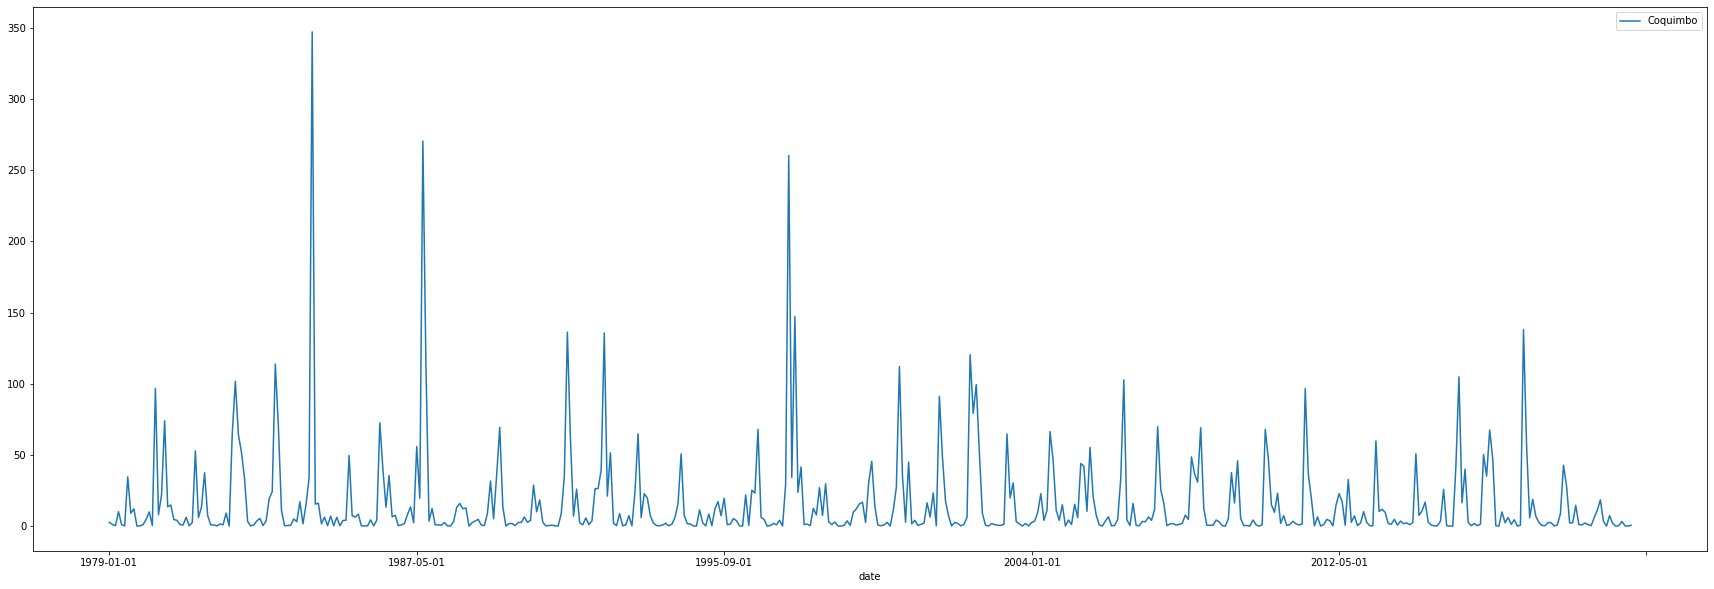

In [29]:
precip=precip.sort_values(by='date')
precip.plot(x='date', y='Coquimbo', figsize=[30,10])
plt.show()

In [184]:
def crear_grafico(region, f_inicio, f_termino):
    try:
        graph_df= precip[precip['date']>= f_inicio]
        graph_df=graph_df[graph_df['date']<= f_termino][['date',region]]
        graph_df=graph_df.sort_values(by='date')
        graph_df.plot(x='date', y=region, figsize=[20,10], xlabel='Fecha', ylabel= 'Milímeteos de lluvia')
    except KeyError:
        print('Error: no existe la columna ingresada en el dataset')
        

    
    

,date,Metropolitana_de_Santiago
15,2000-01-01,0.136980
364,2000-02-01,21.529144
199,2000-03-01,0.109413
463,2000-04-01,23.446896
201,2000-05-01,31.136124
...,...,...
454,2019-09-01,17.457919
412,2019-10-01,12.197718
111,2019-11-01,1.810671
410,2019-12-01,3.601443


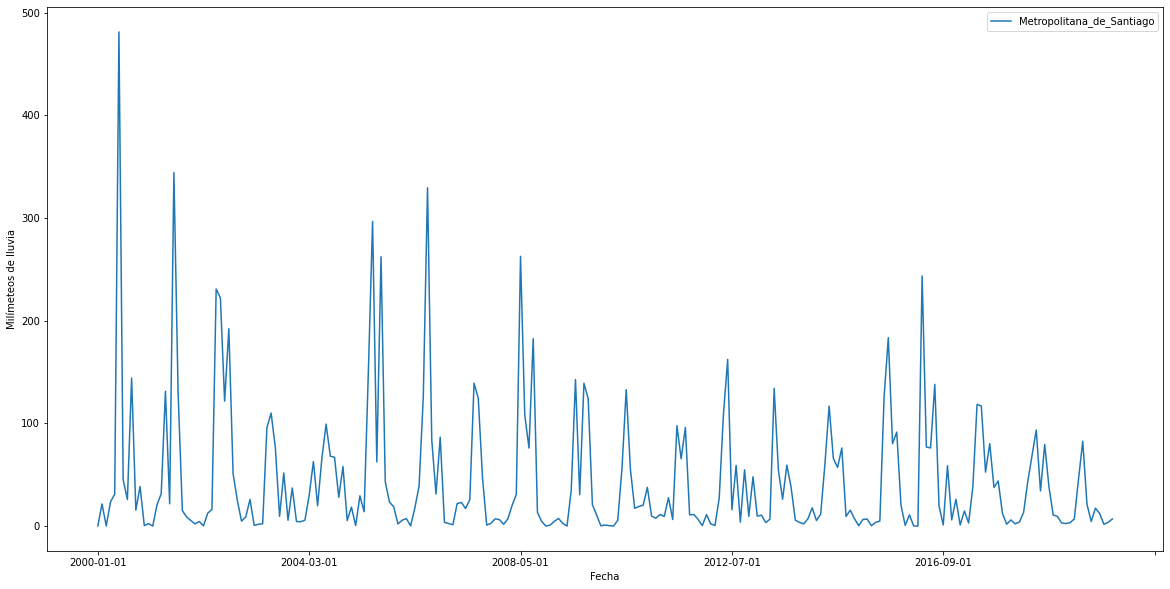

In [172]:
crear_grafico('Metropolitana_de_Santiago','2000-01-01', '2020-01-01')

,date,Libertador_Gral__Bernardo_O_Higgins
15,2000-01-01,0.085411
364,2000-02-01,37.463519
199,2000-03-01,0.049333
463,2000-04-01,28.465287
201,2000-05-01,37.215302
...,...,...
454,2019-09-01,42.662558
412,2019-10-01,13.204651
111,2019-11-01,4.307132
410,2019-12-01,6.198806


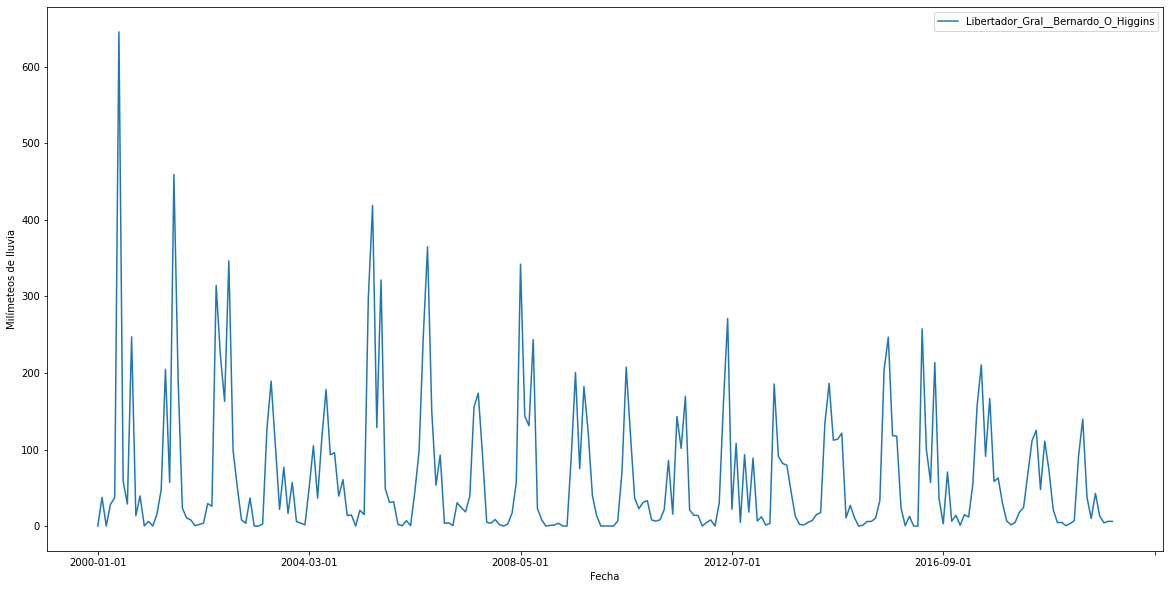

In [173]:
crear_grafico('Libertador_Gral__Bernardo_O_Higgins','2000-01-01', '2020-01-01')

In [112]:
#En general, se ve en ambos casos que el número promedio de milímetros de precipitacioness tiene una tendencia a caer
# a medida que pasa el tiempo, lo cual creo que podemos corroborar empíricamente quienes hemos vivido en alguna de estas regiones
#durante este período. Asimismo, se ve una estacionalidad muy marcada, y muy similar para ambas regiones (probablemente 
#debido a que están muy cerca una de la otra). Esta es un claro aumento en los meses de invierno y luego un descenso hacia 
# los meses de primavera y verano. Sumando ambos efectos, se ve que, en muchos años, el peak de milímetros alcanzados
# en invierno disminuye con respecto a los años anteriores.


In [174]:
def graficos_anuales(años, region):
    #Ordenamos los años para que los gráficos se muestren desde las fechas más pasadas hasta las más recientes
    años.sort()
    for año in años:
        crear_grafico(region,'{}-01-01'.format(año), '{}-12-31'.format(año))

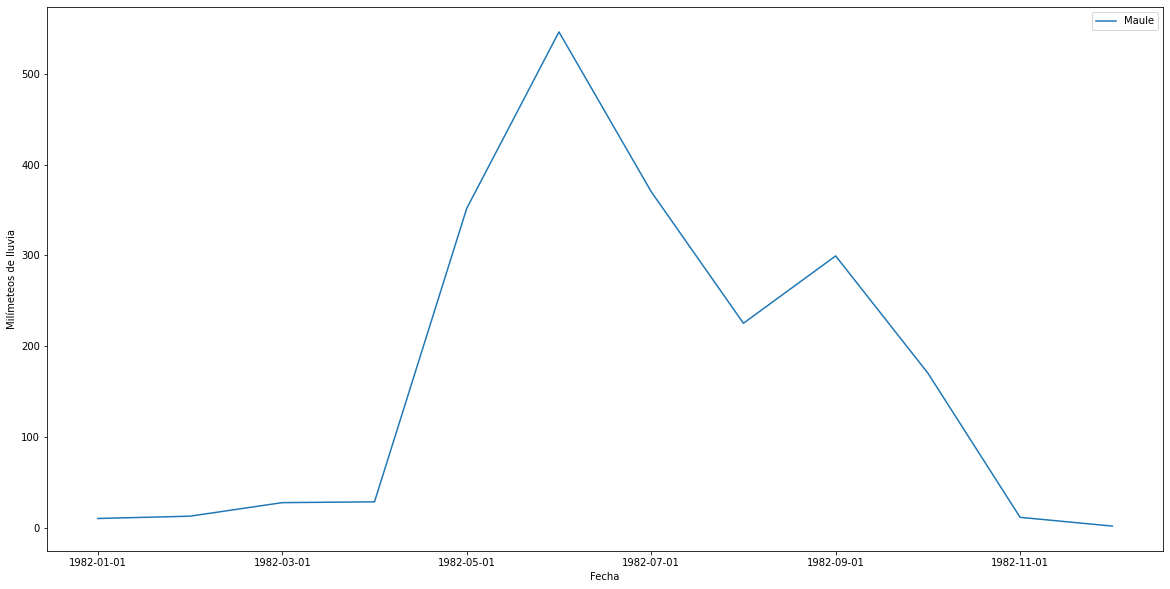

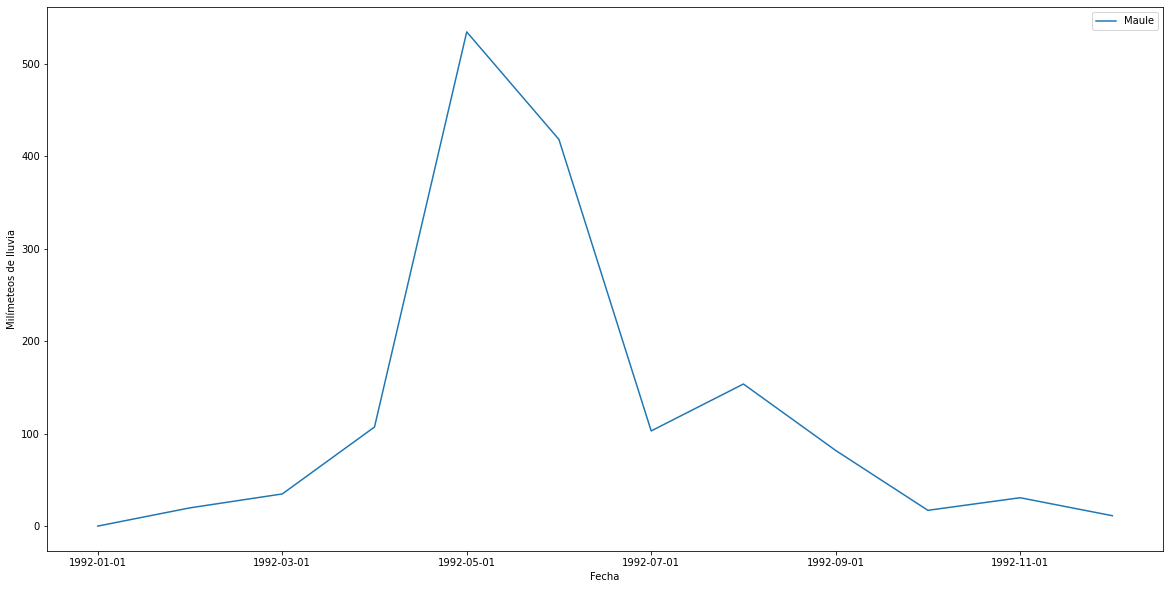

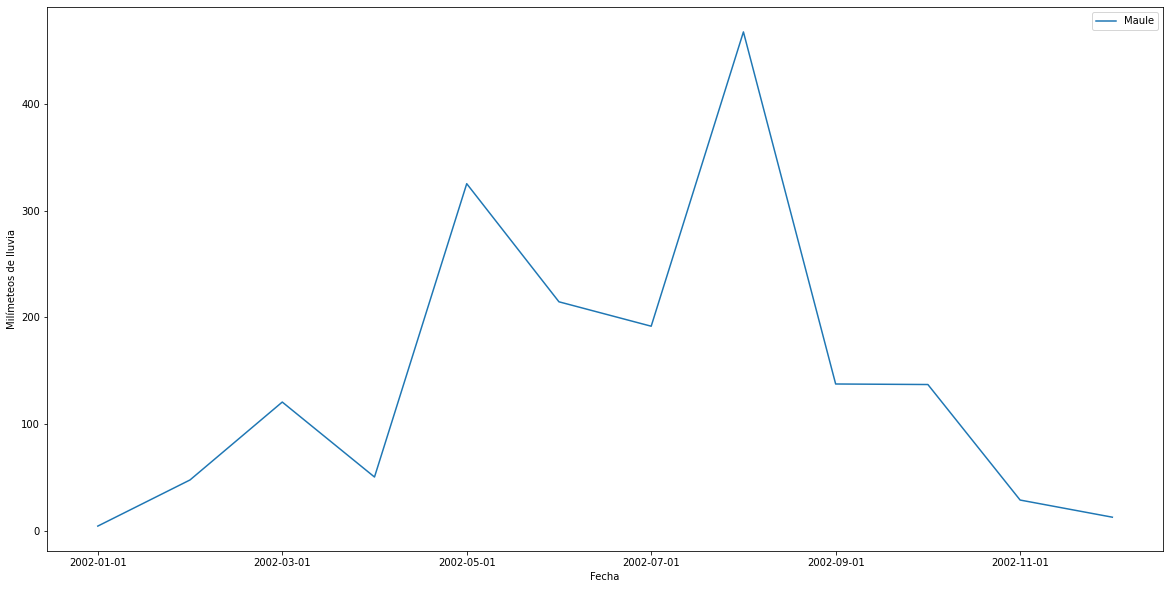

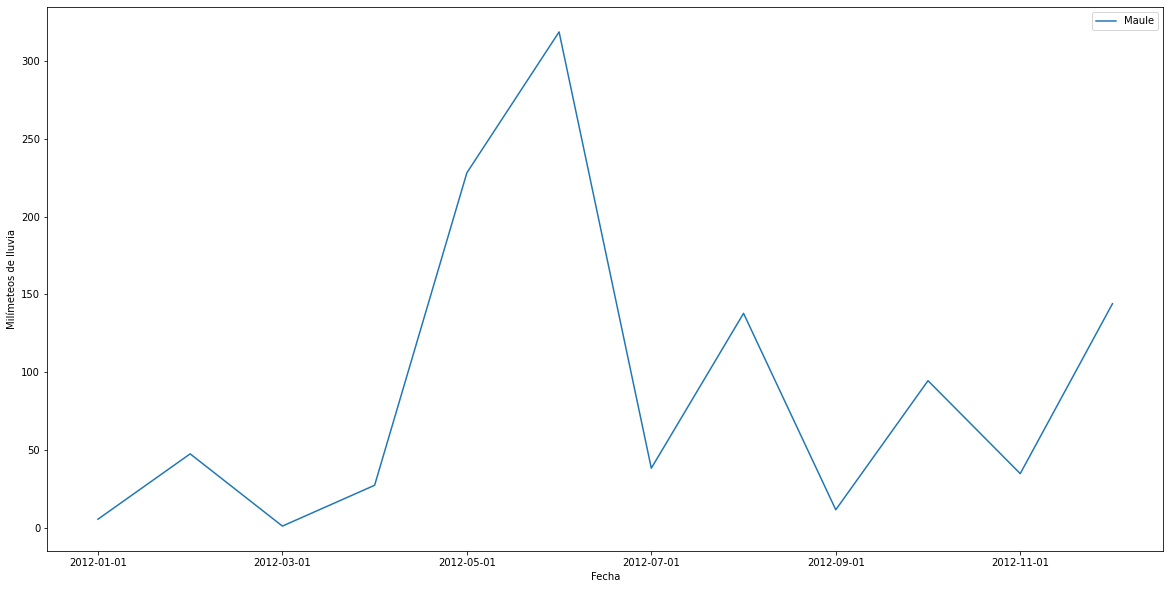

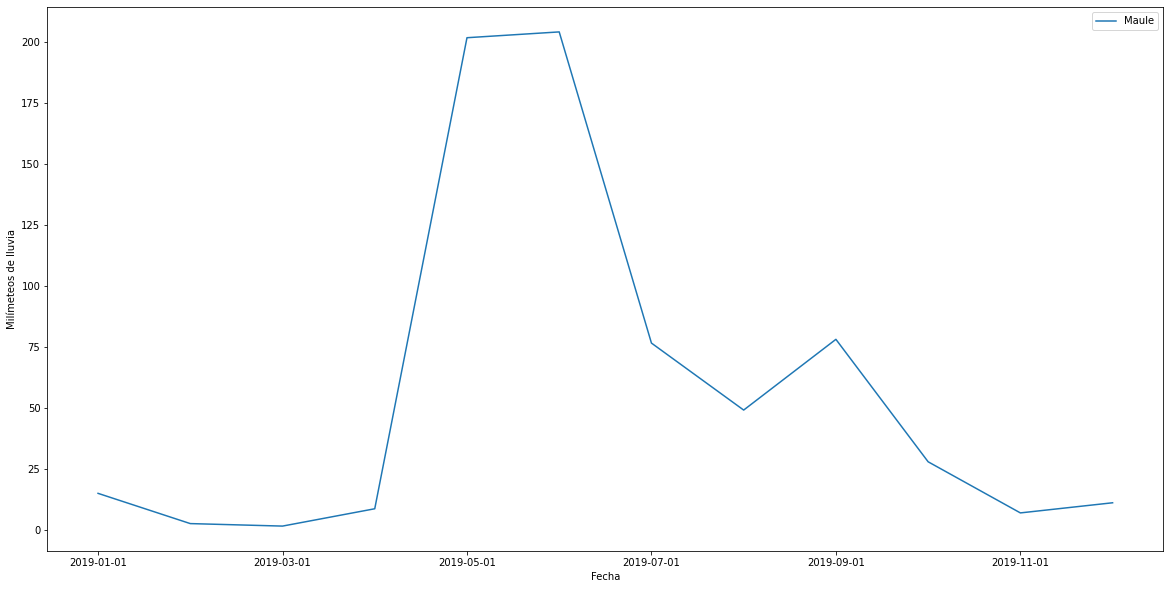

In [175]:
años= ['1982', '1992', '2002', '2012','2019']
graficos_anuales(años,'Maule')

In [163]:
#Similar al caso anterior, se nota en primer lugar la disminución de la caída de lluvia en el Maule: si en 1982 se veían 500 mm aprox
#de lluvia en el mes con mayores precipitaciones, el 2019 este núemro cae a 200.
#En general, no cambia mucho la estacionalidad de la lluvia, siendo el invierno los meses donde se registran las mayores precipitaciones.


In [278]:
def crear_grafico_pib(serie_1, serie_2, f_inicio, f_termino):
    try:
        graph_df= bc[bc['Periodo']>= f_inicio]
        graph_df=graph_df[graph_df['Periodo']<= f_termino][['Periodo',serie_1,serie_2]]
        graph_df=graph_df.sort_values(by='Periodo')
        graph_df=graph_df.set_index('Periodo')

        plt.figure(figsize=(20,5))
        ax =plt.plot(graph_df[[serie_1,serie_2]])
        plt.show()

    except KeyError:
        print('Error: no existe la columna ingresada en el dataset')
    return graph_df
        

    
    

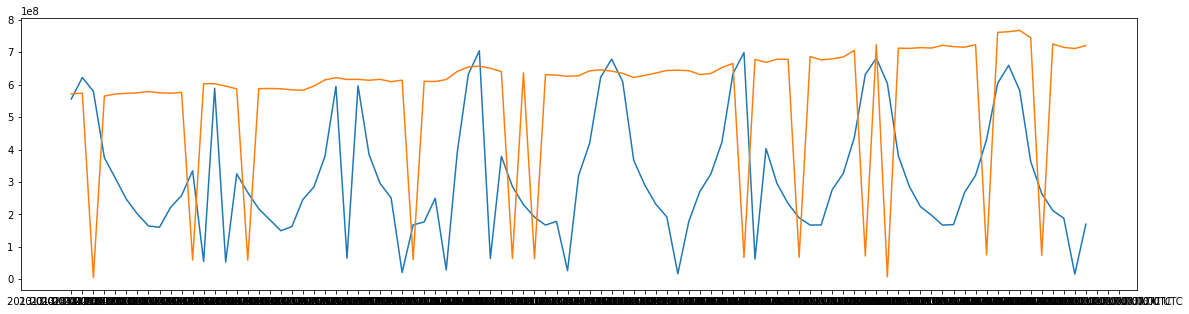

,PIB_Agropecuario_silvicola,PIB_Servicios_financieros
Periodo,,
2013-01-01 00:00:00 UTC,555875498.0,571866642.0
2013-02-01 00:00:00 UTC,622149258.0,573744733.0
2013-03-01 00:00:00 UTC,579846819.0,5691837.0
2013-04-01 00:00:00 UTC,374895706.0,565071466.0
2013-05-01 00:00:00 UTC,311356127.0,571394036.0
...,...,...
2020-08-01 00:00:00 UTC,15867781.0,711575686.0
2020-09-01 00:00:00 UTC,169746171.0,720980294.0
2020-10-01 00:00:00 UTC,NaN,NaN


In [279]:
crear_grafico_pib('PIB_Agropecuario_silvicola', 'PIB_Servicios_financieros', '2013-01-01',bc['Periodo'].max())

In [265]:
# El PIB Agropecuario silvicola parece tener peaks que son periódicos, probablemente debido a la estacionalidad propia de los productos
# de la agricultura o ganadería que se venden en el país. 
# Con respecto al PIB de servicios financieros, se ve que es relativamente estable, con caídas cada cierto tiempo. Habría que estudiar
# en más detalle para ver si existe alguna estacionalidad, o si se debe a factores externos, como crisis económicas.

## 4. Tratamiento y creación de variables

In [ ]:
# Con respecto a la correlación entre las variables dependientes y la independiente, una mayor correlación va a permitir un mayor
# poder predictivo, pues se estaría utilizando información relevante para explicar el fenómeno. Si hay una correlación demasiado
# alta (cercana a 1) será bueno revisar que no haya dependencia en cómo se crearon las variables, pues podría ser que la independiente
# se haya creado a partir de la dependiente, obteniendo overfitting. 
# Con respecto a las variables independientes, entre sí no es bueno que exista una correlación muy alta, pues de lo contrario se 
# podría tener multicolinealidad, un problema que, según el método de estimación que se use, podría complicar el proceso 
# de optimización que se utiliza para obtener los parámetros, dado que crearía una matriz linealmente dependiente que no peude 
# invertirse. 
# Con respecto a los lags, hay que asegurarse de que no exista autocorrelación de los errores o residuos antes de agregarlos al modelo.
# De lo contrario, se arriesga consturir un modelo endógeno, puesto que existiría correlación entre una de las variables independientes
# (el lag, a través de su error, e_t-1) y el residuo, e_t. 


In [280]:
p_leche=pd.read_csv('precio_leche.csv')

In [341]:
meses={'Ene':'01', 'Feb':'02','Mar':'03', 'Abr':'04', 'May':'05', 'Jun':'06', 'Jul':'07', 'Ago':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11',
       'Dic':'12'}
p_leche['n_mes'] = p_leche['Mes'].map(meses)


In [340]:
# pd.options.display.float_format = '{:,.0f}'.format

In [343]:
p_leche['fecha']=pd.to_datetime(p_leche['Anio'].astype(str)  + p_leche['n_mes'].astype(str), format='%Y%m')
bc['Periodo_date']=pd.to_datetime(bc['Periodo'], format='%Y-%d-%m %H:%M:%S UTC')

In [355]:
serie=p_leche.merge(bc, left_on='fecha', right_on='Periodo_date')

In [358]:
serie

,Anio,Mes,Precio_leche,n_mes,fecha,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,...,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos,Periodo_date
0,1979,Ene,4,01,1979-01-01,1979-01-01 00:00:00 UTC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1979-01-01
1,1980,Ene,5,01,1980-01-01,1980-01-01 00:00:00 UTC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980-01-01
2,1981,Ene,7,01,1981-01-01,1981-01-01 00:00:00 UTC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1981-01-01
3,1982,Ene,5,01,1982-01-01,1982-01-01 00:00:00 UTC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1982-01-01
4,1983,Ene,8,01,1983-01-01,1983-01-01 00:00:00 UTC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983-01-01
5,1984,Ene,11,01,1984-01-01,1984-01-01 00:00:00 UTC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1984-01-01
6,1985,Ene,15,01,1985-01-01,1985-01-01 00:00:00 UTC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985-01-01
7,1986,Ene,16,01,1986-01-01,1986-01-01 00:00:00 UTC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1986-01-01
8,1987,Ene,20,01,1987-01-01,1987-01-01 00:00:00 UTC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987-01-01
9,1988,Ene,29,01,1988-01-01,1988-01-01 00:00:00 UTC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988-01-01
